In [1]:
using PyPlot, Random, SpecialFunctions, ProgressMeter

### Experiments for "Mean-Field Lagevin Dynamics: Exponential convergence and annealing"

We consider interacting particles on the 2d torus $(\mathbb{R}/\mathbb{Z})^d$, with a positive semi-definite interaction kernel. 

Definition of the interaction kernel and its derivatives:

In [ ]:
#modified Dirichlet kernel
dc = 1.0 # decay coefficient of the frequency components
dirichlet(x,n)  = (1 + 2*sum(cos.(k*x[1])/(1+k^dc) for k=1:n))*(1 + 2*sum(cos.(k*x[2])/(1+k^dc) for k=1:n))
dirichlet(x,y,n)  = (1 + 2*sum(cos.(k*x)/(1+k^dc) for k=1:n))*(1 + 2*sum(cos.(k*y)/(1+k^dc) for k=1:n))
# the partial derivatives
d1_dirichlet(x,n)  = 2*sum(-k*sin.(k*x[1])/(1+k^dc) for k=1:n)*(1 + 2*sum(cos.(k*x[2])/(1+k^dc) for k=1:n))
d2_dirichlet(x,n)  = 2*sum(-k*sin.(k*x[2])/(1+k^dc) for k=1:n)*(1 + 2*sum(cos.(k*x[1])/(1+k^dc) for k=1:n))


d2_dirichlet (generic function with 1 method)

In [3]:
figure(figsize=[3,3])
xs = range(-π,π,length=100)
pcolor(xs,xs,dirichlet.(xs,xs',4));

The objective function involves the entropy, which we estimate with a nearest-neighbor estimator.

In [4]:
"k-NN entropy estimator for the point cloud X of m points in the d-dimension torus"
function kNN_entropy_est(X,k=1)
    d,m = size(X)
    dists = [ sqrt(sum(min.(mod.(X[:,i]-X[:,j],2π),mod.(-X[:,i]+X[:,j],2π)).^2)) for i=1:m, j=1:m ] #computes twice as much as needed
    kdist = [partialsort(dists[:,i], k+1) for i=1:m]
    return - digamma(m) + digamma(k) - (d/2)*log(π) + log(gamma(1+d/2)) - (d/m)*sum(log.(kdist))
end

kNN_entropy_est

Main algorithm that computes the evolution of the particles

In [5]:
function PGD(X_init, X_target, tau, niter; annealed=true)
stepsize = 0.08
n = 5 #nb of freq component in the Dirichlet kernel
grad=zeros(d,m)
G = zeros(niter-1)
H = zeros(niter-1)
F = zeros(niter-1)
X = zeros(d, m , niter)
X[:,:,1] = X_init
tau_t = tau
for t = 1:niter-1
    G[t] = ( sum(dirichlet(X[:,i,t] - X[:,j,t],n) for i=1:m, j=1:m)/m^2 
            - 2*sum(dirichlet(X[:,i,t] - X_target[:,j],n) for i=1:m, j=1:m_target)/(m*m_target)
            + sum(dirichlet(X_target[:,i] - X_target[:,j],n) for i=1:m_target, j=1:m_target)/m_target^2)
    
    H[t] = kNN_entropy_est(X[:,:,t],1)
    if annealed
        tau_t = tau*(t+1)^(-1)
    else
        tau_t = tau
    end
    F[t] = G[t] + tau_t * H[t]
    for i=1:m
        grad[1,i] = (sum( d1_dirichlet(X[:,i,t] - X[:,j,t], n) for j=1:m)/m 
                        - sum( d1_dirichlet(X[:,i,t] - X_target[:,j], n ) for j=1:m_target)/m_target )
        grad[2,i] = (sum( d2_dirichlet(X[:,i,t] - X[:,j,t], n) for j=1:m)/m 
                        - sum( d2_dirichlet(X[:,i,t] - X_target[:,j], n ) for j=1:m_target)/m_target )
    end
    if t>niter*0.8
        X[:,:,t+1] = X[:,:,t] .- stepsize * grad
    else 
        X[:,:,t+1] = X[:,:,t] .- stepsize * grad .+ sqrt(2*stepsize*tau_t) * randn(d,m)
    end
end
    return X, G, H, F
end

PGD (generic function with 1 method)

In [6]:
# apply landscape modification to the gradient
function grad_LM(G_t, grad, iter; c, alpha_init, decay_factor, f, epsilon)
    alpha = alpha_init * (decay_factor^iter)
    mod_factor = alpha * f(max(0, (G_t - c))) + epsilon
    return grad / mod_factor
end

grad_LM (generic function with 1 method)

In [ ]:
function PGD_LM(X_init, X_target, tau, niter; 
                c = Inf, alpha_init=1.0, decay_factor=1, f = x -> x^2, epsilon = 1.0, c_adaptive=true, annealed=true)
    stepsize = 0.08
    n = 5  #nb of freq component in the Dirichlet kernel
    grad = zeros(d, m)
    G = zeros(niter-1)
    H = zeros(niter-1)
    F = zeros(niter-1)
    X = zeros(d, m , niter)
    X[:,:,1] = X_init
    tau_t = tau

    for t = 1:niter-1
        G[t] = ( sum(dirichlet(X[:,i,t] - X[:,j,t], n) for i=1:m, j=1:m)/m^2 
                - 2*sum(dirichlet(X[:,i,t] - X_target[:,j], n) for i=1:m, j=1:m_target)/(m*m_target)
                + sum(dirichlet(X_target[:,i] - X_target[:,j], n) for i=1:m_target, j=1:m_target)/m_target^2)
        
        # Update running minimum of the potential function
        if c_adaptive
            c = min(c, G[t])
        end

        H[t] = kNN_entropy_est(X[:,:,t], 1)
        if annealed
            tau_t = tau * (t + 1)^(-1)
        else
            tau_t = tau
        end

        F[t] = G[t] + tau_t * H[t]

        for i = 1:m
            grad_unmodified_1 = (sum(d1_dirichlet(X[:,i,t] - X[:,j,t], n) for j=1:m)/m 
                         - sum(d1_dirichlet(X[:,i,t] - X_target[:,j], n) for j=1:m_target)/m_target)
            
            grad_unmodified_2 = (sum(d2_dirichlet(X[:,i,t] - X[:,j,t], n) for j=1:m)/m 
                         - sum(d2_dirichlet(X[:,i,t] - X_target[:,j], n) for j=1:m_target)/m_target) 
            grad[1, i] = grad_LM(G[t], grad_unmodified_1, t; c, alpha_init, decay_factor, f, epsilon)

            grad[2, i] = grad_LM(G[t], grad_unmodified_2, t; c, alpha_init, decay_factor, f, epsilon)

        end

        if t > niter * 0.8
            X[:,:,t+1] = X[:,:,t] .- stepsize * grad
        else 
            X[:,:,t+1] = X[:,:,t] .- stepsize * grad .+ sqrt(2 * stepsize * tau_t) * randn(d, m)
        end
end

    return X, G, H, F
end

PGD_LM (generic function with 1 method)

# Illustration

In [8]:
Random.seed!(1)
niter=1000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
d=2
X_target = 2π*rand(d, m_target) # ground truth
X_init = 2π*rand(d, m); # random init

Random.seed!(1)
@time X, G, H, F = PGD(X_init, X_target, 0.1, niter, annealed=false);
Random.seed!(1)
@time X_LM, G_LM, H_LM, F_LM = PGD_LM(X_init, X_target, 0.1, niter, annealed=false);

 24.594051 seconds (748.56 M allocations: 13.904 GiB, 4.34% gc time, 9.82% compilation time)
 22.166118 seconds (742.77 M allocations: 13.592 GiB, 4.08% gc time, 2.04% compilation time)


In [9]:
figure(figsize=[10,4])
subplot(121)
plot(F,label=L"F=G+\tau H")
plot(G,label=L"G")
plot(H,label=L"H")
vlines(800,-5,5,"k",ls="--",label="Noise stopped")
legend()
xlabel("iteration count")
subplot(122)
axis([0,2π,0,2π])
plot(X_target[1,:], X_target[2,:],"o",ms=10,color="C0",label="fixed ground truth")
plot(mod.(X[1,:,end],2π),mod.(X[2,:,end],2π),"oC3",ms=3,label="particles")
title("Final particles configuration")
legend()
plt.savefig("Final particles configuration")

In [10]:
figure(figsize=[10,4])
subplot(121)
plot(F_LM,label=L"F=G+\tau H")
plot(G_LM,label=L"G")
plot(H_LM,label=L"H")
vlines(800,-5,5,"k",ls="--",label="Noise stopped")
legend()
xlabel("iteration count")
subplot(122)
axis([0,2π,0,2π])
plot(X_target[1,:], X_target[2,:],"o",ms=10,color="C0",label="fixed ground truth")
plot(mod.(X_LM[1,:,end],2π),mod.(X[2,:,end],2π),"oC3",ms=3,label="particles")
title("Final particles configuration with landscape modification")
legend()
plt.savefig("Final particles configuration with LM")

# Convergence speed without annealing (long)

In [11]:
Random.seed!(1)
niter=1000 #1000
d = 2
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
nrep = 10 #nb of repetitions 
taus = [0.03,0.1,0.3]
Fs = zeros(nrep,length(taus),niter-1)
Fs_LM = zeros(nrep, length(taus), niter-1)
for i=1:length(taus)
@showprogress "Computing..."   for j=1:nrep
        X_target = 2π*rand(d, m_target)
        X_init = 2π*rand(d, m);

        X, G, H, F = PGD(X_init, X_target, taus[i], niter, annealed=false);
        Fs[j,i,:] = F

        X_LM, G_LM, H_LM, F_LM = PGD_LM(X_init, X_target, taus[i], niter, annealed=false)
        Fs_LM[j, i, :] = F_LM
    end
end

Computing... 100%|███████████████████████████████████████| Time: 0:07:19
Computing... 100%|███████████████████████████████████████| Time: 0:07:15
Computing... 100%|███████████████████████████████████████| Time: 0:07:15


In [12]:
using PyPlot

# Example data (Replace with actual data)
N, _, total_iterations = 100, 3, 1000  

# Compute A values for PGD and PGD_LM
A1 = sum(Fs[:,1,1:800] .- minimum(Fs[:,1,:],dims=2), dims=1)' ./ 10
A2 = sum(Fs[:,2,1:800] .- minimum(Fs[:,2,:],dims=2), dims=1)' ./ 10
A3 = sum(Fs[:,3,1:800] .- minimum(Fs[:,3,:],dims=2), dims=1)' ./ 10

A1_LM = sum(Fs_LM[:,1,1:800] .- minimum(Fs_LM[:,1,:],dims=2), dims=1)' ./ 10
A2_LM = sum(Fs_LM[:,2,1:800] .- minimum(Fs_LM[:,2,:],dims=2), dims=1)' ./ 10
A3_LM = sum(Fs_LM[:,3,1:800] .- minimum(Fs_LM[:,3,:],dims=2), dims=1)' ./ 10

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=true)
fig.suptitle("Convergence Comparison of PGD vs PGD with LM (Without Annealing)", fontsize=14, fontweight="bold")

taus = [0.03, 0.1, 0.3]
A_vals = [(A1, A1_LM, 0.4), (A2, A2_LM, -1.1), (A3, A3_LM, -5.4)]
pgd_colors = ["C0", "C1", "C2"]
pgd_lm_colors = ["C3", "C4", "C5"]

for i in 1:3
    A, A_LM, offset = A_vals[i]
    axs[i].semilogy([sum(A[j:j+10]) .+ offset for j=1:790], pgd_colors[i], lw=2, label=L"PGD")
    axs[i].semilogy([sum(A_LM[j:j+10]) .+ offset for j=1:790], pgd_lm_colors[i], lw=2, label=L"PGD_{LM}")
    
    axs[i].set_xlabel("Iteration Count")
    axs[i].set_title("\$\\tau = $(taus[i])\$")
    axs[i].legend()
end

axs[1].set_ylabel(L"F_\tau(\mu_t)+C")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Ensure the plot saving and display statements are separate
plt.savefig("convergence_comparison_tau_no_annealing.png", bbox_inches="tight")
plt.show()


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


# Grid Search

In [64]:
using Random
using PyPlot
using ProgressMeter

Random.seed!(1)

c_values = [100, 50, 10, 1.0, 0.1, Inf]  # If Inf, c is adaptive; otherwise, it's fixed.
alpha_values = [100, 50, 10, 1.0, 0.1]
decay_factors = [1.0, 0.99, 0.9]
f1(x) = x
f2(x) = x^2
f3(x) = x^3
f_functions = [f1, f2, f3]

# control
default_c = Inf
default_alpha = 1.0
default_decay = 1.0
default_f = x -> x
default_tau = 0.1

niter = 1000
m_target = 10 
m = 50        
nrep = 10      


results = Dict()

function run_experiment(param_name, param_values)
    for param in param_values
        key = (param_name, param)
        Fs = zeros(nrep, niter-1)
        for j in 1:nrep
            X_target = 2π * rand(d, m_target)
            X_init = 2π * rand(d, m)
            X, G, H, F = PGD_LM(X_init, X_target, default_tau, niter;
                c = param_name == "c" ? param : default_c,
                alpha_init = param_name == "alpha" ? param : default_alpha,
                decay_factor = param_name == "decay_factor" ? param : default_decay,
                f = param_name == "f_function" ? param : default_f,
                epsilon = 1.0, 
                c_adaptive = (param_name == "c" ? param == Inf : true),
                annealed = true
            )

            Fs[j, :] = F
        end
        results[key] = Fs
    end
end

println("Testing different values of c...")
@showprogress for param in c_values
    run_experiment("c", [param])
end

println("Testing different values of alpha...")
@showprogress for param in alpha_values
    run_experiment("alpha", [param])
end

println("Testing different values of decay factor...")
@showprogress for param in decay_factors
    run_experiment("decay_factor", [param])
end

println("Testing different functions f(x)...")
@showprogress for param in f_functions
    run_experiment("f_function", [param])
end

# Run PGD without LM for comparison with default parameters
Fs_default = zeros(nrep, niter-1)
for j in 1:nrep
    X_target = 2π * rand(d, m_target)
    X_init = 2π * rand(d, m)
    X, G, H, F = PGD(X_init, X_target, default_alpha, niter, annealed=true)
    Fs_default[j, :] = F
end


Testing different values of c...


Progress: 100%|█████████████████████████████████████████| Time: 0:22:10


Testing different values of alpha...


Progress: 100%|█████████████████████████████████████████| Time: 0:18:26


Testing different values of decay factor...


Progress: 100%|█████████████████████████████████████████| Time: 0:11:04


Testing different functions f(x)...


Progress: 100%|█████████████████████████████████████████| Time: 0:11:07


In [129]:
using Plots

figure(figsize=[12, 12])
param_categories = ["c", "alpha", "decay_factor", "f_function"]

for (i, category) in enumerate(param_categories)
    subplot(2, 2, i)  

    for (key, Fs) in results
        param_name, param_value = key isa Tuple ? key : ("Default", "PGD")

        if param_name == category
            A = sum(Fs[:, 1:800] .- minimum(Fs[:, :], dims=2), dims=1)' / 10
            label_str = param_name == "c" && param_value == Inf ? "$(param_name) Adaptive" : "$(param_name)=$(param_value)"
            semilogy([sum(A[i:i+10]) for i=1:790], lw=2, label=label_str)
        end
    end

    # Add the PGD default line to each subplot
    A_default = sum(Fs_default[:, 1:800] .- minimum(Fs_default[:, :], dims=2), dims=1)' / 10
    semilogy([sum(A_default[i:i+10]) for i=1:790], "k--", lw=2, label="PGD Default")

    legend()
    xlabel("Iteration Count")
    ylabel(L"F_\tau(\mu_t) + C")
    title("Convergence for $(category) Parameter Tuning")
end

savefig("individual_param_search_subplots.png", dpi=300, bbox_inches="tight")


# Convergence speed with annealing & comparison PGD vs NPGD (long)


In [15]:
# takes 5 minutes
Random.seed!(1)
niter=1000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
G1s = zeros(niter-1, 10)  # PGD with tau = 0.0
G2s = zeros(niter-1, 10)  # PGD with tau = 20.0
G1s_LM = zeros(niter-1, 10)  # PGD_LM with tau = 0.0
G2s_LM = zeros(niter-1, 10)  # PGD_LM with tau = 20.0

@showprogress "Computing..." for k=1:10
    X_target = 2π * rand(d, m_target)
    X_init = 2π * rand(d, m)

    # Run original PGD with different tau values
    X1, G1 = PGD(X_init, X_target, 0.0, niter, annealed=true)
    X2, G2 = PGD(X_init, X_target, 20.0, niter, annealed=true)

    # Run PGD with landscape modification
    X1_LM, G1_LM = PGD_LM(X_init, X_target, 0.0, niter, annealed=true)
    X2_LM, G2_LM = PGD_LM(X_init, X_target, 20.0, niter, annealed=true)

    # Store results
    G1s[:, k] = G1
    G2s[:, k] = G2
    G1s_LM[:, k] = G1_LM
    G2s_LM[:, k] = G2_LM
end


Computing... 100%|███████████████████████████████████████| Time: 0:14:31


In [16]:
figure(figsize=[4,3])
for k=1:10
semilogy(G1s[:,k],alpha=0.1,"C0")
semilogy(G2s[:,k],alpha=0.1,"C1")
end
semilogy(sum(G1s,dims=2)/10,"C0",lw=2,label="PGD")
semilogy(sum(G2s,dims=2)/10,"C1",lw=2,label="NPGD (annealed)")
vlines(800,0.002,10,"k",ls="--",label="Noise stopped")
legend(loc=3)
xlabel("Iteration count")
ylabel(L"G(\mu_t)-\inf G")
axis([0,1000,0.002,3])
savefig("compare-NPGD.png",bbox_inches="tight")

# Video animation

In [18]:
# takes 30 sec
Random.seed!(2)
niter=2000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
X_target = 2π*rand(d, m_target)
X_init = 2π*rand(d, m);
@time X1, G1 = PGD(X_init, X_target, 0.0, niter,annealed=false); #no noise
@time X2, G2 = PGD(X_init, X_target, 20, niter,annealed=true); # noise # choose annealed (tau=20) or not (tau=0.1)
@time X1_LM, G1_LM = PGD_LM(X_init, X_target, 0.0, niter,annealed=false); #no noise, with landscape modification
@time X2_LM, G2_LM = PGD(X_init, X_target, 20, niter,annealed=true); # noise # choose annealed (tau=20)or not (tau=0.1), with landscape modification

 44.924301 seconds (1.48 G allocations: 27.077 GiB, 5.64% gc time)
 44.533538 seconds (1.48 G allocations: 27.080 GiB, 5.35% gc time, 0.20% compilation time)
 44.314371 seconds (1.48 G allocations: 27.121 GiB, 5.40% gc time)
 44.641711 seconds (1.48 G allocations: 27.077 GiB, 5.35% gc time)


In [19]:
# original
figure(figsize=[4,3])
semilogy(G1,label=L", no noise")
plot(G2,label=L", noise")
vlines(0.8*niter,0.002,10,"k",ls="--",label="Noise stopped")
legend();

In [36]:
using Printf

# Create frames directory
mkpath("frames")

# Function to generate and save animation frames manually
function save_frame(t)
    figure(figsize=(10, 4))

    for (i, (X, title_str)) in enumerate([(X1, "No noise (PGD)"), (X2, "Noise (NPGD)"),
                                          (X1_LM, "No noise (PGD_LM)"), (X2_LM, "Noise (NPGD_LM)")])
        subplot(2, 2, i)
        axis([0, 2π, 0, 2π])
        plot(mod.(X[1, :, t], 2π), mod.(X[2, :, t], 2π), "ko", ms=3)
        plot(X_target[1, :], X_target[2, :], "oC3")
        PyPlot.xticks([0, 2π], ["0", "2π"])
        PyPlot.yticks([0, 2π], ["0", "2π"])
        title(title_str)
    end

    savefig(@sprintf("frames/%04d.png", t), dpi=150, bbox_inches="tight")
    close()
end

# Save frames every 50 iterations
for t in 1:50:niter
    save_frame(t)
    close()
end

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Sorted files: ["0001.png", "0051.png", "0101.png", "0151.png", "0201.png", "0251.png", "0301.png", "0351.png", "0401.png", "0451.png", "0501.png", "0551.png", "0601.png", "0651.png", "0701.png", "0751.png", "0801.png", "0851.png", "0901.png", "0951.png", "1001.png", "1051.png", "1101.png", "1151.png", "1201.png", "1251.png", "1301.png", "1351.png", "1401.png", "1451.png", "1501.png", "1551.png", "1601.png", "1651.png", "1701.png", "1751.png", "1801.png", "1851.png", "1901.png", "1951.png"]


┌ Info: Saved animation to /Users/mulan/NUS/Research/UROP/animation.gif
└ @ Plots /Users/mulan/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/Users/mulan/NUS/Research/UROP/animation.gif")
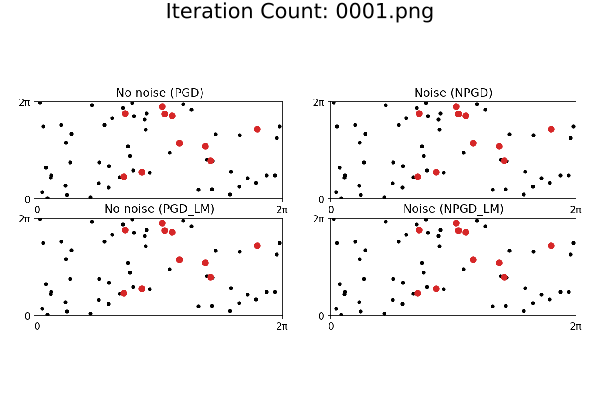

In [ ]:
using Plots, Images

# Use GR backend for efficient plotting
gr()

# Directory containing the frames
frame_dir = "frames"

# Function to extract numeric part from filename
function extract_frame_number(filename)
    m = match(r"(\d+)", filename)  # Extract numeric part from filename
    return m !== nothing ? parse(Int, m.match) : nothing
end

# Get list of valid image files (ignoring hidden/system files)
frame_files = filter(f -> endswith(f, ".png") && !startswith(f, "."), readdir(frame_dir))

# Sort files numerically by their extracted frame numbers
sorted_files = sort(frame_files, by = x -> extract_frame_number(x))

# Print sorted files for verification
println("Sorted files: ", sorted_files)

animation_result = @animate for file in sorted_files
    img = load(joinpath(frame_dir, file))
    heatmap(img, color=:grays, framestyle=:none, ticks=false, title="Iteration Count: $file")
end
gif(animation_result, "animation.gif", fps=15)

# add plot for objective function

    

# plot for paper (iteration $t=1500$)

In [22]:
figure(figsize=[4,4])
axis([0,2π,0,2π])
plot(mod.(X2[1,:,1500],2π),mod.(X2[2,:,1500],2π),"ko",ms=3)
plot(X_target[1,:], X_target[2,:],"oC3")
PyPlot.xticks([0,2π],["0","2π"])
PyPlot.yticks([0,2π],["0","2π"]);
    #savefig("config.png",bbox_inches="tight")

(PyCall.PyObject[PyObject <matplotlib.axis.YTick object at 0x2b73169f0>, PyObject <matplotlib.axis.YTick object at 0x2b74065a0>], PyCall.PyObject[PyObject Text(0, 0.0, '0'), PyObject Text(0, 6.283185307179586, '2π')])